In [1]:
import re
import numpy as np #
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib.ticker import FuncFormatter
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
df = pd.read_csv('test_data.csv', parse_dates=['date'], date_parser=dateparse)
df['date_time'] = pd.to_datetime(df['time'], unit='s')

In [3]:
df = df.sort_values(by='time').reset_index(drop=True)
# время в индекс, чтобы можно было делать resample
df = df.set_index('date_time')
df.head(3)

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date
date_time,,,,,,,,,,
2019-04-01 00:00:48,1.554077e+09,click,CPM,0,no_agency,client_31916,campaign_44282,ad_44282,web,2019-04-01
2019-04-01 00:01:03,1.554077e+09,view,CPC,0,no_agency,client_51,campaign_8339,ad_8339,android,2019-04-01
2019-04-01 00:01:09,1.554077e+09,view,CPM,0,no_agency,client_108,campaign_10356,ad_10356,android,2019-04-01


## 1. Воспроизведите график числа рекламных событий по дням

In [4]:
sns.set(rc={'figure.figsize':(19, 7), 'axes.titlesize':16, 'axes.labelsize':14, 'xtick.labelsize':12, 
            'ytick.labelsize':12,'axes.titlepad': 30, # 'font.family': 'Roboto' 
           })

In [5]:
def daily_plot(data, group_var=None, group_title=None, ax=None, color='#45678f'):
    """Функция для построения графиков за несколько дней. 
    По оси х - дни, у - количество действий. 
    Также возможна группировка по еще одной переменной, например, типу взаимодействия.
    
    Параметры
    ---------
    data: pandas DataFrame
        Датасет
    group_var: str, optional
        Название группирующей переменной
    group_title: str, optional
        Название легенды 
    ax: axis, optional
        Если объект axis уже создан (полезно при построении нескольких графиков сразу)
    color: str, optional
        Цвет линии
    """
    if ax is None:
        fig, ax = plt.subplots()    
        
    # агрегировать данные
    if group_var:
        data_TMP = data.groupby(['date', group_var]).size().reset_index(name='counts')
        for val in data_TMP[group_var].unique().tolist():
            ax.plot(data_TMP[data_TMP[group_var] == val].date, data_TMP[data_TMP[group_var] == val].counts, 
                    label=val, linewidth=3, markersize=6, marker='o')
        ax.legend(data_TMP[group_var].unique().tolist(), title=group_title, loc='best', framealpha=0)
    else:
        data_TMP = data.groupby(['date']).size().reset_index(name='counts')  # df.resample(rule='D').count()
        ax.plot(data_TMP.date, data_TMP.counts, color=color,
                linewidth=3, markersize=6, marker='o')
        
    ax.set(xlabel='Дни', ylabel='Количество действий с рекламными объявлениями', 
           title='Распределение действий с рекламными объявлениями')
    # чтобы было красиво
    ax.set_frame_on(False) # sns.despine() 
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, p: '{:,g}k'.format(y/1000)))
    ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 2)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_minor_locator(mdates.YearLocator(month=4, day=2))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%Y'))
    
    ax.grid(True, color='#e2e2e2', alpha=0.5)
    
    #return fig, ax

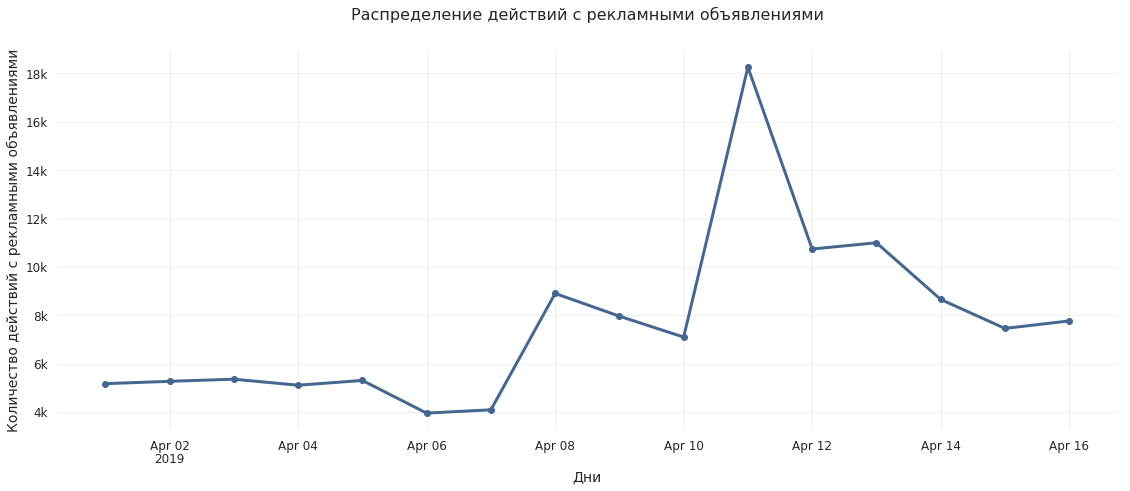

In [6]:
daily_plot(df)

## 2. Найдите причину резкого увеличения количества рекламных событий и объясните, что произошло

In [7]:
df.shape

(122097, 10)

In [8]:
df.nunique()

time                 113789
event                     3
ad_cost_type              2
has_video                 2
agency_union_id         351
client_union_id        8709
campaign_union_id     12330
ad_id                 18049
platform                  5
date                     16
dtype: int64

При удалении дубликатов ничего сильно не изменилось, а значит проблема не в этом.

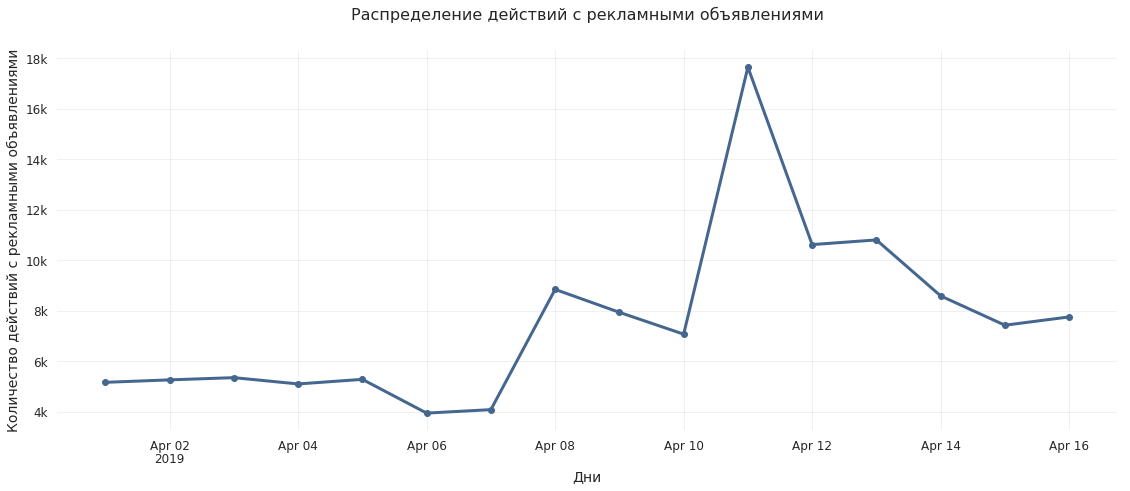

In [9]:
daily_plot(df.drop_duplicates())

На основе графиков, приведенных ниже, можно заметить, что с 8 апреля число показов объявлений начало расти, а 11 апреля достигло наибольшей отметки.  
1. действия: очень выросло количество показов, при этом число кликов и жалоб не увеличилось
2. тип: CPC (плата за клик)
3. без видео
4. больше всего - с платформы android *(стоило бы посмотреть в процентах, а не просто на числа)*

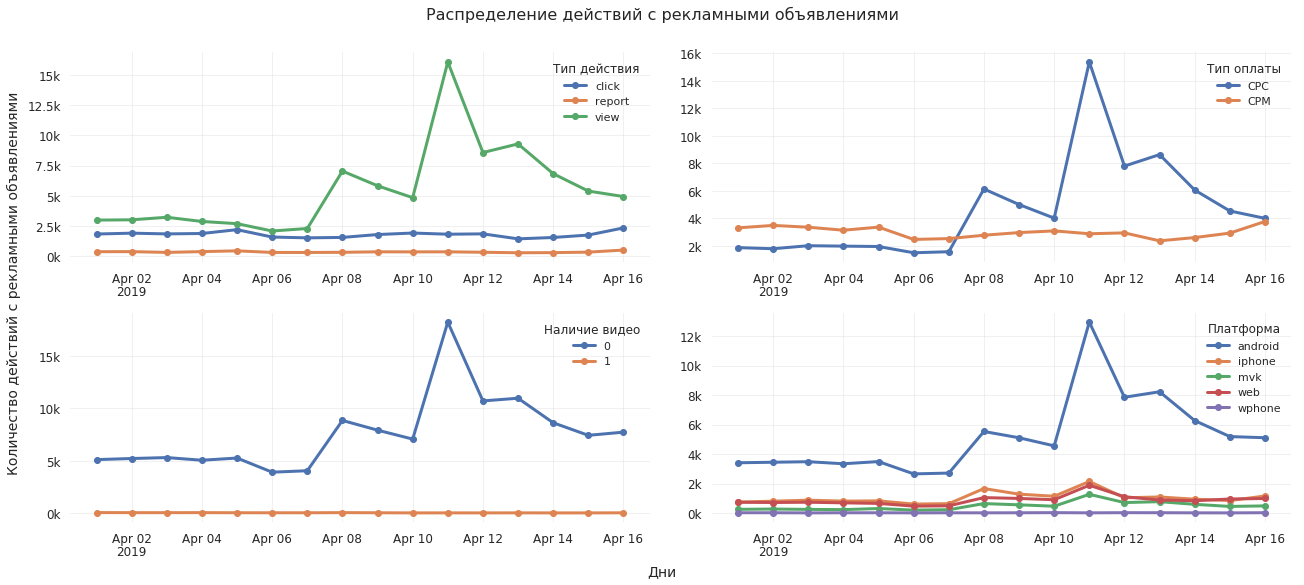

In [10]:
# почему бы не построить сразу в одном месте
cols_to_plot = ['event', 'ad_cost_type', 'has_video', 'platform']

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(18, 8))
fig.subplots_adjust(hspace=0.4, wspace=0.15)
fig.suptitle('Распределение действий с рекламными объявлениями', fontsize=16)

for ax, col, leg in zip(axes.flatten(), cols_to_plot, ['Тип действия', 'Тип оплаты', 'Наличие видео','Платформа']):
    daily_plot(df, col, ax=ax)
    ax.set(xlabel='', ylabel='', title='')
    ax.legend(title=leg, loc='upper right', framealpha=0)
    
fig.text(0.00, 0.5, 'Количество действий с рекламными объявлениями', rotation='vertical', va='center', ha='center', fontsize=14)
fig.text(0.5, 0.00, 'Дни', va='center', ha='center', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Посмотрим, как изменилось число реклам: может их просто стало больше? Или всё сломалось из-за чего-то одного? 
Логично предположить, что проблема может быть вызвана каким-то конкретным объектом, если дело не в дубликатах, а всё растет кое как.  
Для начала, возьмем **топ-5 агентств по количеству действий** для каждого дня:

In [11]:
# был топ 10, но тогда на графике получалось многовато всего, поэтому я решила сделать как танос и оставила 5
top_agency_ids = df.groupby(['date', 'agency_union_id']).size().sort_values(ascending=False)\
.groupby('date').head(5).reset_index(name='cnt').sort_values(by='date')
top_agency_ids.head(11) # ура работает

,date,agency_union_id,cnt
59,2019-04-01,agency_2,88
29,2019-04-01,agency_33,219
26,2019-04-01,agency_158,256
10,2019-04-01,no_agency,3339
45,2019-04-01,agency_70,120
32,2019-04-02,agency_33,190
30,2019-04-02,agency_158,199
47,2019-04-02,agency_2,115
8,2019-04-02,no_agency,3435
53,2019-04-02,agency_70,94


Что же мы видим? 
- До 8 апреля больше всего действий происходило с рекламными объявлениями без агентства  
- С 8 до 15 апреля *(кроме 9 & 10)* больше всего действий было у **agency_2**
- Пик: 11 апреля

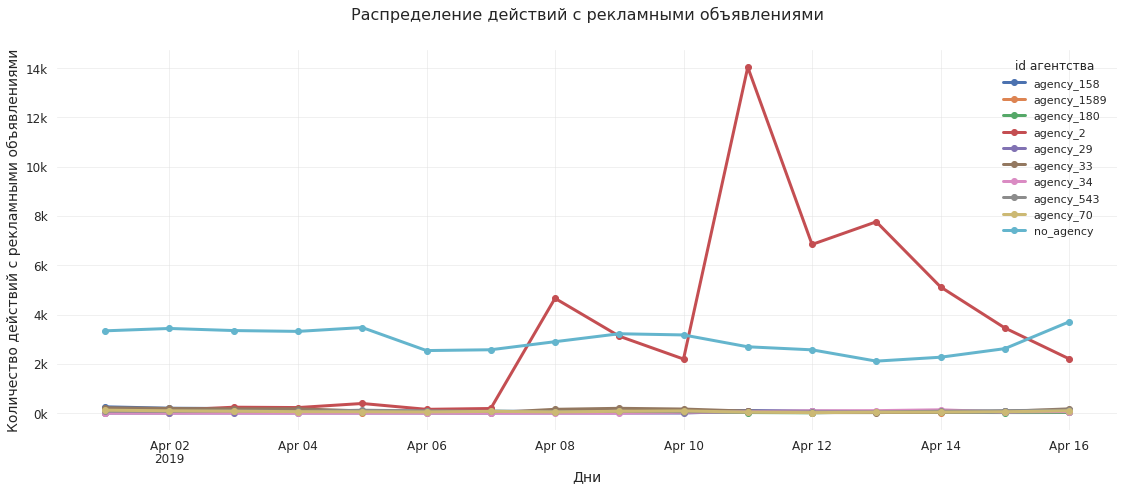

In [12]:
daily_plot(df.query('agency_union_id in @top_agency_ids.agency_union_id'), group_var='agency_union_id', group_title='id агентства')

***
![](https://pp.userapi.com/c851436/v851436067/121512/g4PX3c3gj5s.jpg)

***

Более подробно посмотрим на то, что происходило с графиками для агентства 2 *(которые почти дублируют группу из 4 графиков выше)*:
1. Распределение всех действий: очень похоже на изначальный график, виден явный пик    
2. В зависимости от типа действия: резкие скачки показов, клики не меняются, есть немного жалоб   
3. CPC/CPM: CPC, т.е. оплата за клики *(которых почти нет)*    
4. Платформа: больше всего с android

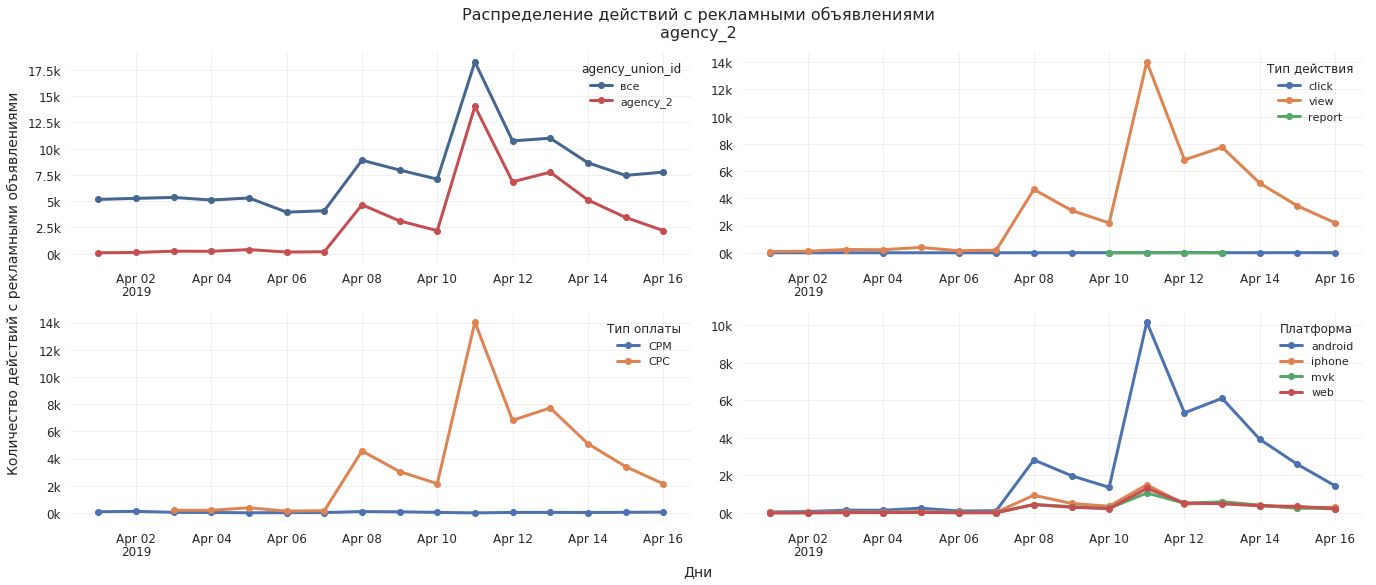

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(19, 8))
#fig.subplots_adjust(hspace=0.4, wspace=0.15)
fig.suptitle('Распределение действий с рекламными объявлениями\nagency_2\n', fontsize=16)

daily_plot(df, ax=axes.flatten()[0])
daily_plot(df.query('agency_union_id=="agency_2"'), ax=axes.flatten()[0], color='r')
axes.flatten()[0].legend(('все', 'agency_2'), title='agency_union_id', loc='best', framealpha=0)
axes.flatten()[0].set(xlabel='', ylabel='', title='')

for ax, col, leg in zip(axes.flatten()[1:], ['event', 'ad_cost_type', 'platform'], ['Тип действия', 'Тип оплаты', 'Платформа']):
    daily_plot(df.query('agency_union_id=="agency_2"'), col, ax=ax)
    ax.set(xlabel='', ylabel='', title='')
    ax.legend(title=leg, loc='upper right', framealpha=0)
    
fig.text(0.00, 0.5, 'Количество действий с рекламными объявлениями', rotation='vertical', va='center', ha='center', fontsize=14)
fig.text(0.5, 0.00, 'Дни', va='center', ha='center', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

Теперь нужно проверить, причиной скачков стала одна реклама, несколько, или что-то еще?

In [14]:
# топ-3 рекламы за каждый день по количеству действий
top_per_day = df.groupby(['date', 'agency_union_id', 'client_union_id', 'campaign_union_id', 'ad_id']).size()\
.sort_values(ascending=False).groupby('date').head(3).reset_index(name='cnt').sort_values(by='date')
top_per_day.head()

,date,agency_union_id,client_union_id,campaign_union_id,ad_id,cnt
23,2019-04-01,no_agency,client_48,campaign_7701,ad_7701,197
35,2019-04-01,agency_33,client_99583,campaign_99643,ad_99643,102
37,2019-04-01,agency_158,client_106190,campaign_106256,ad_106256,78
39,2019-04-02,agency_2,client_47296,campaign_97294,ad_97427,73
38,2019-04-02,agency_33,client_99583,campaign_99643,ad_99643,76


In [15]:
# оставить только те рекламы, у которых число действий больше среднего 
# (иначе на графике получается многовато всего, поэтому и не медиана)
#med_cnt = np.median(top_per_day.cnt)
mean_cnt = np.mean(top_per_day.cnt)
strange_ads = top_per_day.sort_values(by=['cnt'], ascending=False).query('cnt > @ mean_cnt').ad_id.unique()
strange_ads

array(['ad_49554', 'ad_49556', 'ad_49560', 'ad_49564'], dtype=object)

Посмотрим на агрегированные показатели реклам, которые привели к скачкам на графике *(не по дням, а вообще за всё время сбора)*
1. Всего подозрительных объявлений четыре  
2. Все они от **agency_2**, **client_47270**, **campaign_49554**    
3. Тип трат рекламного объявления: CPC  
4. Очень много показов, но почти совсем нет кликов --> CTR тоже низкий  
5. При этом показов больше всего среди пользователей android 

In [16]:
df.query('ad_id in @strange_ads').groupby(['ad_id','event','platform','ad_cost_type','agency_union_id', 'client_union_id', 'campaign_union_id']).size().reset_index(name='cnt')\
.pivot_table(index=['agency_union_id','client_union_id', 'campaign_union_id','ad_id','ad_cost_type',], columns=['event','platform'], values='cnt').reset_index().fillna(0)

event    agency_union_id client_union_id campaign_union_id     ad_id  \
platform                                                               
0               agency_2    client_47270    campaign_49554  ad_49554   
1               agency_2    client_47270    campaign_49554  ad_49556   
2               agency_2    client_47270    campaign_49554  ad_49560   
3               agency_2    client_47270    campaign_49554  ad_49564   

event    ad_cost_type   click              report            view          \
platform              android iphone  web android iphone  android  iphone   
0                 CPC    23.0    2.0  6.0     4.0    1.0  21015.0  2194.0   
1                 CPC     2.0    0.0  1.0     0.0    0.0   6080.0   804.0   
2                 CPC     5.0    0.0  1.0     1.0    0.0   4888.0  1247.0   
3                 CPC     3.0    0.0  2.0     0.0    0.0   2642.0   718.0   

event                     
platform     mvk     web  
0         2154.0  2101.0  
1          526.0   805.0  
2          708.0   646.0  
3          532.0   594.0

In [17]:
# общая табличка для агентства 2
df.query('agency_union_id == "agency_2"').groupby(['ad_id','event','platform','ad_cost_type','agency_union_id', 'client_union_id', 'campaign_union_id']).size().reset_index(name='cnt')\
.pivot_table(index=['agency_union_id','client_union_id', 'campaign_union_id','ad_id','ad_cost_type',], columns=['event','platform'], values='cnt').reset_index().fillna(0)

event    agency_union_id client_union_id campaign_union_id     ad_id  \
platform                                                               
0               agency_2    client_47269    campaign_47269  ad_47269   
1               agency_2    client_47269    campaign_47279  ad_49136   
2               agency_2    client_47270    campaign_49554  ad_49554   
3               agency_2    client_47270    campaign_49554  ad_49556   
4               agency_2    client_47270    campaign_49554  ad_49560   
5               agency_2    client_47270    campaign_49554  ad_49564   
6               agency_2    client_47270    campaign_49554  ad_50872   
7               agency_2    client_47296    campaign_97293  ad_97293   
8               agency_2    client_47296    campaign_97294  ad_97427   
9               agency_2    client_47296    campaign_97296  ad_97784   
10              agency_2    client_47296    campaign_97299  ad_97803   
11              agency_2    client_47296    campaign_97306  ad_97944   
12              agency_2    client_47296    campaign_97307  ad_97994   
13              agency_2    client_47296    campaign_98057  ad_98057   
14              agency_2    client_98042    campaign_98060  ad_98060   
15              agency_2    client_98052    campaign_98061  ad_98061   
16              agency_2    client_98053    campaign_98063  ad_98063   
17              agency_2    client_98058    campaign_98064  ad_98064   

event    ad_cost_type   click              report            view          \
platform              android iphone  web android iphone  android  iphone   
0                 CPC     0.0    1.0  0.0     0.0    0.0   1164.0   370.0   
1                 CPC     0.0    0.0  0.0     0.0    0.0    290.0    77.0   
2                 CPC    23.0    2.0  6.0     4.0    1.0  21015.0  2194.0   
3                 CPC     2.0    0.0  1.0     0.0    0.0   6080.0   804.0   
4                 CPC     5.0    0.0  1.0     1.0    0.0   4888.0  1247.0   
5                 CPC     3.0    0.0  2.0     0.0    0.0   2642.0   718.0   
6                 CPC     0.0    0.0  0.0     0.0    0.0     22.0     5.0   
7                 CPM     0.0    0.0  0.0     0.0    0.0     79.0    33.0   
8                 CPM     0.0    0.0  0.0     0.0    0.0    214.0   103.0   
9                 CPM     0.0    0.0  0.0     0.0    0.0     12.0     4.0   
10                CPM     0.0    0.0  0.0     0.0    0.0     93.0    38.0   
11                CPM     0.0    0.0  0.0     0.0    0.0     30.0    12.0   
12                CPM     0.0    0.0  0.0     0.0    0.0     34.0    22.0   
13                CPM     2.0    1.0  0.0     0.0    0.0      0.0     0.0   
14                CPM     1.0    0.0  0.0     0.0    0.0      0.0     0.0   
15                CPM     2.0    0.0  0.0     0.0    0.0      0.0     0.0   
16                CPM     0.0    1.0  0.0     0.0    0.0      0.0     0.0   
17                CPM     1.0    0.0  0.0     0.0    0.0      0.0     0.0   

event                     
platform     mvk     web  
0          201.0   131.0  
1           28.0    23.0  
2         2154.0  2101.0  
3          526.0   805.0  
4          708.0   646.0  
5          532.0   594.0  
6            4.0     3.0  
7           17.0     5.0  
8           24.0    16.0  
9            2.0     1.0  
10          10.0     0.0  
11           7.0     1.0  
12           5.0     2.0  
13           0.0     0.0  
14           0.0     0.0  
15           0.0     0.0  
16           0.0     0.0  
17           0.0     0.0

На основе 1 графика можно сделать вывод, что без учета этих рекламных объявлений изначальный график выглядит весьма нормально *(серая линия)*.   
Второй график показывает количество действий с объявлениями для **client_47270**, которому принадлежат эти 4 объявления, также сгруппированных по id рекламной кампании. Судя по всему, других объявлений у этого клиента не было, т.к. статистика начинается с одного и того же дня, а id кампании у него тоже только один.

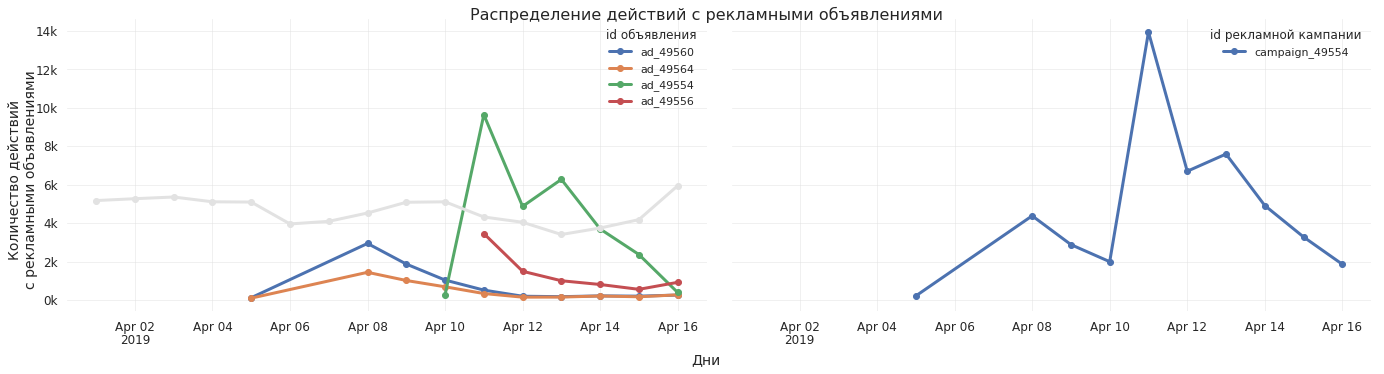

In [18]:
fig, axes = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(19,5))
fig.subplots_adjust(hspace=0.4, wspace=0.15)
fig.suptitle('Распределение действий с рекламными объявлениями', fontsize=16)
daily_plot(df.query('ad_id in @strange_ads'), group_var='ad_id', group_title='id объявления', ax=axes.flatten()[0])
daily_plot(df.query('ad_id not in @strange_ads'), ax=axes.flatten()[0], color='#e2e2e2')
daily_plot(df.query('client_union_id == "client_47270"'), group_var='campaign_union_id', group_title='id рекламной кампании',
           ax=axes.flatten()[1])
for ax in axes.flatten():
    ax.set(xlabel='', ylabel='', title='')
fig.text(0.0, 0.5, 'Количество действий\nс рекламными объявлениями', rotation='vertical'
         , va='center', ha='center', fontsize=14)
fig.text(0.5, 0.0, 'Дни', va='center', ha='center', fontsize=14)
plt.tight_layout()
plt.show()

Значит, проблема скорее не в самом агентстве 2, а в его **конкретной рекламной кампании**. Если посмотреть на статистику для данного агентства, можно заметить, что есть и другие объявления/кампании, с которыми никаких странных скачков не произошло.

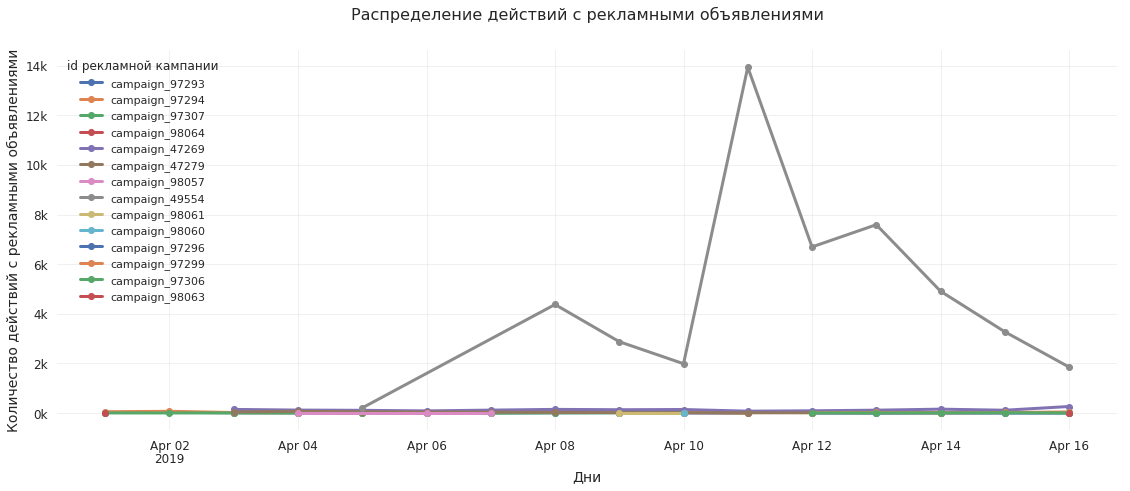

In [19]:
daily_plot(df.query('agency_union_id == "agency_2"'), group_var='campaign_union_id', group_title='id рекламной кампании')

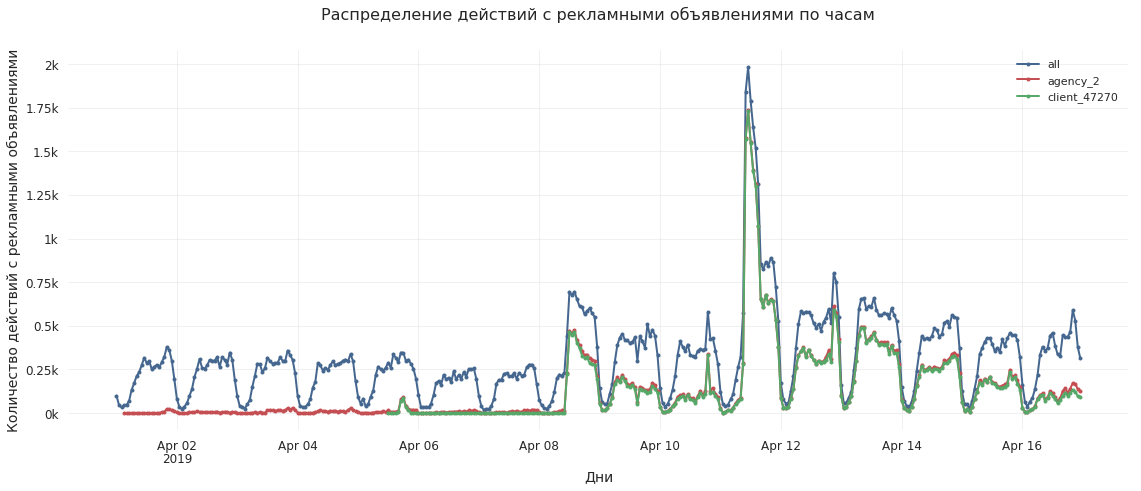

In [20]:
df_hourly = df.resample(rule='H').count()
df_hourly_ag2 = df.query('agency_union_id == "agency_2"').resample(rule='H').count()
df_hourly_cl = df.query('client_union_id == "client_47270"').resample(rule='H').count()
fig, ax = plt.subplots()
ax.plot(df_hourly.index, df_hourly.event, color='#45678f', linewidth=2, markersize=3, marker='o')
ax.plot(df_hourly_ag2.index, df_hourly_ag2.event, color='r', linewidth=2, markersize=3, marker='o')
ax.plot(df_hourly_cl.index, df_hourly_cl.event, color='g', linewidth=2, markersize=3, marker='o')
ax.legend(('all', 'agency_2', 'client_47270'), title='',loc='best', framealpha=0)
ax.set(xlabel='Дни', ylabel='Количество действий с рекламными объявлениями', title='Распределение действий с рекламными объявлениями по часам')
ax.set_frame_on(False) # sns.despine() 
ax.yaxis.set_major_formatter(FuncFormatter( lambda y, p: '{:,g}k'.format(y/1000) ))
ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 2)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_minor_locator(mdates.YearLocator(month=4, day=2))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%Y'))
plt.grid(True, color='#e2e2e2', alpha=0.5)

**Так что же в итоге могло случиться?** На основе всей информации выше можно сделать несколько основных выводов.
1. Скорее всего, ошибки в сборе данных не произошло. Дубликатов очень мало, и при их удалении общая картина не меняется. Если бы что-то сломалось/перестало считаться/собираться, то это было бы заметно: например, что-то бы совсем обнулилось, или же такая проблема коснулась бы большинства объявлений. Здесь же проблема оказалась в одной кампании конкретного агентства.
2. Кликбейта/скликивания/прочего тоже не произошло, ведь увеличились показы, а кликов больше не стало. Точнее, их вообще почти нет. 
3. Остаётся вариант: неправильные настройки рекламы. Показы есть, причём весьма много - значит, реклама показывалась. Но кликов практически нет, соответственно, объявления пользователей не интересуют. Жалоб тоже весьма мало, так что с самим текстом объявления все должно быть нормально *(+ они же проходят модерацию)*. Тип платы за рекламное объявление - CPC, т.е. за клик, а не за показы, так что сам клиент сильно не пострадал с: 


Для того, чтобы совсем точно понять причину произошедшего, было бы неплохо посмотреть настройки таргета, место показа объявлений (лента/рекомендации/другое) и, возможно, на сами рекламные объявления. И на пользователей - они точно были реальными?
***

## 3. Детектирование аномальных изменений 
Task(*): Предложите способ, который помог бы автоматически детектировать аномальные изменения метрик на графиках рекламной статистики.   
- Предложите алгоритм, который каждое утро анализирует данные за прошедшие сутки, и, если они сильно выбиваются из общего тренда, отправляет аналитику уведомление: на этом графике есть проблема за вчерашний день  
- Подумайте, как сделать детектор, который проверяет на аномалии каждый час, каждые пять минут в графике? 
- Предложите вариант кода, который решает эту задачу. Реализовывать логику нотификации не нужно, только поиск аномального дня, часа, пятиминутки в данных рекламной статистики.
***

![](https://pp.userapi.com/c850728/v850728351/11f837/IeTmf9FDOwU.jpg)  

### Moving Average & CI
Один из возможных и простых вариантов: посчитать скользящее среднее (moving average), чтобы сгладить график, построить доверительные интервалы, и если значение выходит за его рамки - считать его аномальным. В целом, такой метод основан на предположении о том, что последнее значение зависит от среднего значения $n$ предыдущих наблюдений. Этот метод не всегда подходит, если есть какие-то сезонные аномалии, но почему бы не попробовать.

$$SMA_t = \frac{1}{n}\sum_{i=0}^{n-1}x_{t-i} = \frac{x_t + x_{t-1} + ... + x_{t-(n-1)}}{n}$$

Функция `moving_avg` принимает на вход исходный датасет, размер окна *(чем больше, тем более сглаженный будет ряд)*, считает число рекламных событий в зависимости от указанного периода *(по часам, минутам и т.п.)*, и далее подсчитывает скользящее среднее. Потом строится интервал *(с учетом параметров score & bound_param)*, и если какие-то наблюдения выходят за его границы, то они считаются аномалиями. Также можно вывести график *(весь/набл. зн./тренд, ниже есть примеры)*.   

Как станет понятно далее, такой вариант хорошо работает, если правильно выбрать окно, resample rule и границы доверительного интервала. Графики и процесс размышлений описаны ниже :)


Можно закодить подсчет среднего самостоятельно:

In [21]:
def moving_average(data, window=5):
    """
    Подсчет скользящего среднего.
    """
    wndw = np.ones(int(window))/float(window)
    rolling_mean = np.convolve(data, wndw, 'valid')

    return rolling_mean

In [22]:
df_hourly = df.resample(rule='H').size()

In [23]:
%%time
moving_average(df_hourly, 2)[:5]

CPU times: user 450 µs, sys: 77 µs, total: 527 µs
Wall time: 563 µs


array([73. , 39.5, 39.5, 46.5, 58. ])

Но в pandas есть собственная реализация, так что в дальнейшем используется она 

In [24]:
%%time
df_hourly.rolling(window=2).mean().head()

CPU times: user 2.1 ms, sys: 0 ns, total: 2.1 ms
Wall time: 1.56 ms


date_time
2019-04-01 00:00:00     NaN
2019-04-01 01:00:00    73.0
2019-04-01 02:00:00    39.5
2019-04-01 03:00:00    39.5
2019-04-01 04:00:00    46.5
Freq: H, dtype: float64

In [64]:
def moving_avg(data, resample_rule='H', window=2, plot=False, score=1.96, ax=None, 
               bounds='both', bound_param='r--', obs=True, trend=True, day=None, extended=False):
    """Поиск аномалий на основе скользящего среднего и доверительных интервалов.
    
    Параметры
    ---------
    data: pandas DataFrame
        Датасет
    resample_rule: str
        По какому периоду агрегировать данные (дни/часы и т.п.)
    window: int
        Размер окна
    plot: bool, optional
        True, если нужно вывести график
    scale: float, optional
        Z-значение для доверительного интервала
    ax: axis, optional
        Если объект axis уже создан 
        (полезно при построении нескольких графиков сразу)
    bounds: str
        Верхняя или обе границы интервала ('upper' / 'both')
    bound_param: str, optional
        Цвет и тип линии для CI
    obs: bool, optional
        True, если на графике нужна линия наблюдаемых значений
    trend: bool, optional
        True, если на графике нужна линия тренда (среднего)
    day:
        День, для которого смотрим статистику
    extended:
        True, если нужно вывести аномальные события
    """
    
    data_res = pd.DataFrame(data.resample(rule=resample_rule).size(), columns=['cnt'])
    rolling_mean = data_res.rolling(window=window).mean()

    # доверительные интервалы
    # две границы, т.к. могут быть как очень большие, так и подозрительно маленькие значения
    std = np.std(data_res[window:] - rolling_mean[window:])
    lower_bound = rolling_mean - (score * std)
    upper_bound = rolling_mean + (score * std)

    # ищем аномалии
    anomalies = pd.DataFrame(index=data_res.index, columns=data_res.columns)
    anomalies[data_res < lower_bound] = data_res[data_res < lower_bound]
    anomalies[data_res > upper_bound] = data_res[data_res > upper_bound]
    
    # plot it!
    if plot:
        if ax is None:        
            fig, ax = plt.subplots()  
        if obs:
            ax.plot(data_res[window:], label='наблюдаемые значения', color='#45678f')
        if trend:
            ax.plot(rolling_mean, 'g', label='линия тренда')
        if bounds == 'both':
            ax.plot(upper_bound, bound_param, label='границы')
            ax.plot(lower_bound, bound_param)
        elif bounds == 'upper':
            ax.plot(upper_bound, bound_param, label='верхняя граница')
            anomalies = pd.DataFrame(index=data_res.index, columns=data_res.columns)
            anomalies[data_res > upper_bound] = data_res[data_res > upper_bound]
        ax.plot(anomalies, 'ro', markersize=7, label = 'аномалии')
        ax.set_frame_on(False)
        ax.yaxis.set_major_formatter(FuncFormatter( lambda y, p: '{:,g}k'.format(y/1000)))
        ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 2)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax.xaxis.set_minor_locator(mdates.YearLocator(month=4, day=2))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%Y'))    
        #ax.axes.set_ylim(bottom=0)  # границы интервала иногда бывают ниже 0 
        ax.set(xlabel='Дни', ylabel='Количество действий с рекламными объявлениями', 
               title='Скользящее среднее\nwindow: {}, resample: {}, score: {}'.format(window, resample_rule, score))
        ax.legend(loc='best', framealpha=0)
        ax.grid(True, color='#e2e2e2', alpha=0.5)
    
    # уведомление
    return anomaly_alert(anomalies, day, extended)

In [61]:
def anomaly_alert(anomalies, day, extended):
    if day: 
        anomalies_count = anomalies[day:day].count().values[0]
    else:
        anomalies_count = anomalies.count().values[0]
    
    if anomalies_count > 0:
        print('День: {}\nЧто-то пошло не так, пора проверить графики.\nНайдено аномалий: {}'.format(day, anomalies_count))
        if extended:
            print(anomalies[day:day].dropna() if day else anomalies.dropna())
    else:
        print('День: полный выбранный период\nВсе хорошо')

#### Дни
Поскольку задача состоит в том, чтобы найти **аномалии в данных за прошедшие сутки**, возьмем данные за 11 и 10 апреля *(т.е. сравним статистику за нужный день с предыдущим днем)*, а также за 9, т.к. если мы возьмем наблюдения только за два дня *(агр. по дням)*, то сравнивать будет нечего *(NaN & одно значение)*. Получается, что нужно брать данные за интересующий день и два предыдущих.  


In [27]:
df['2019-04-09':'2019-04-11'].resample('D').count().rolling(window=2).mean()

,time,event,ad_cost_type,has_video,agency_union_id,client_union_id,campaign_union_id,ad_id,platform,date
date_time,,,,,,,,,,
2019-04-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-10,7530.5,7530.5,7530.5,7530.5,7530.5,7530.5,7530.5,7530.5,7530.5,7530.5
2019-04-11,12678.5,12678.5,12678.5,12678.5,12678.5,12678.5,12678.5,12678.5,12678.5,12678.5


Пример: данные с 1 по 11 апреля, агрегированные по дням. Аномалии за 11 апреля обнаруживаются (ура).

День: None
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 1
              cnt
date_time        
2019-04-11  18259


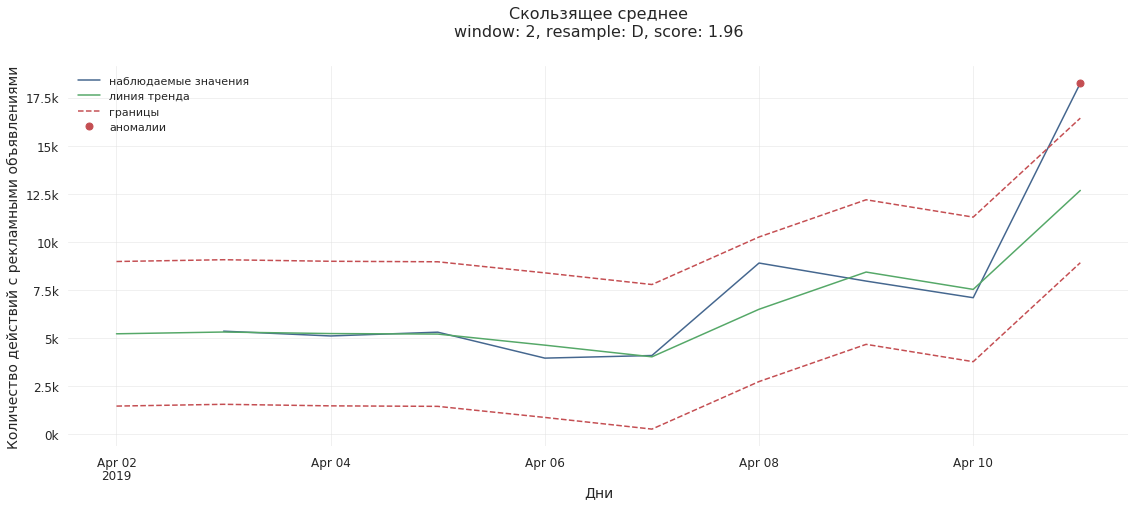

In [63]:
moving_avg(df['2019-04-01':'2019-04-11'], resample_rule='D', plot=True, window=2, extended=True)

#### Статистика по часам
А если по часам? Тоже. *(По идее, если агрегировать данные по часам и брать окно 24, то получается что-то вроде дневной статистики)*  
Немного графиков с разным размером окна, сначала для всей истории наблюдений:

День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 15
День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 16
День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 13
День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 12


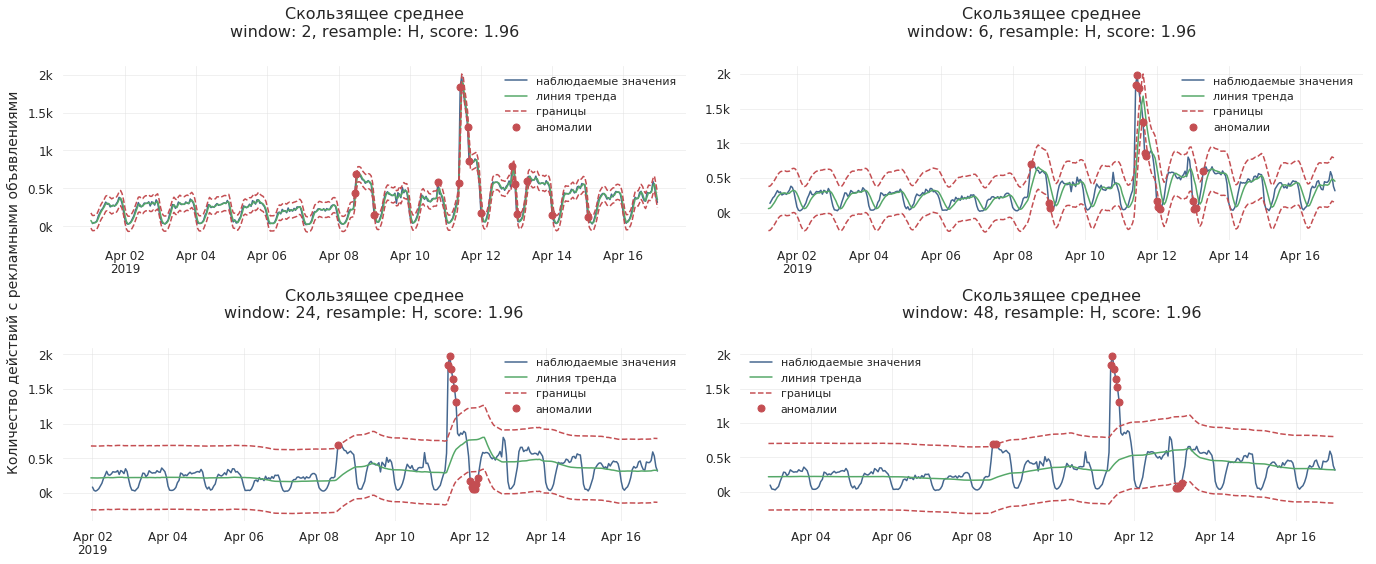

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(19,8))
for ax, window in zip(axes.flatten(), [2, 6, 24, 48]):
    moving_avg(df, resample_rule='H', window=window, plot=True, ax=ax)
for ax in axes.flatten():
    ax.set(xlabel='', ylabel='')
fig.text(0.0, 0.5, 'Количество действий с рекламными объявлениями', rotation='vertical', va='center', ha='center', fontsize=14)
plt.tight_layout()
plt.show()

А теперь для 10-11 апреля. На основе графиков и текстов сообщений можно заметить, что аномалии нашлись, резкий скачок произошел около 10 утра 11.04.  
На первом графике данные берутся по часам, а не дням, но парой ячеек выше я пришла к выводу, что данные по часам + окно 24 = almost дневная статистика, поэтому на втором графике - окно 24. Ух.

День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 2
День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 3


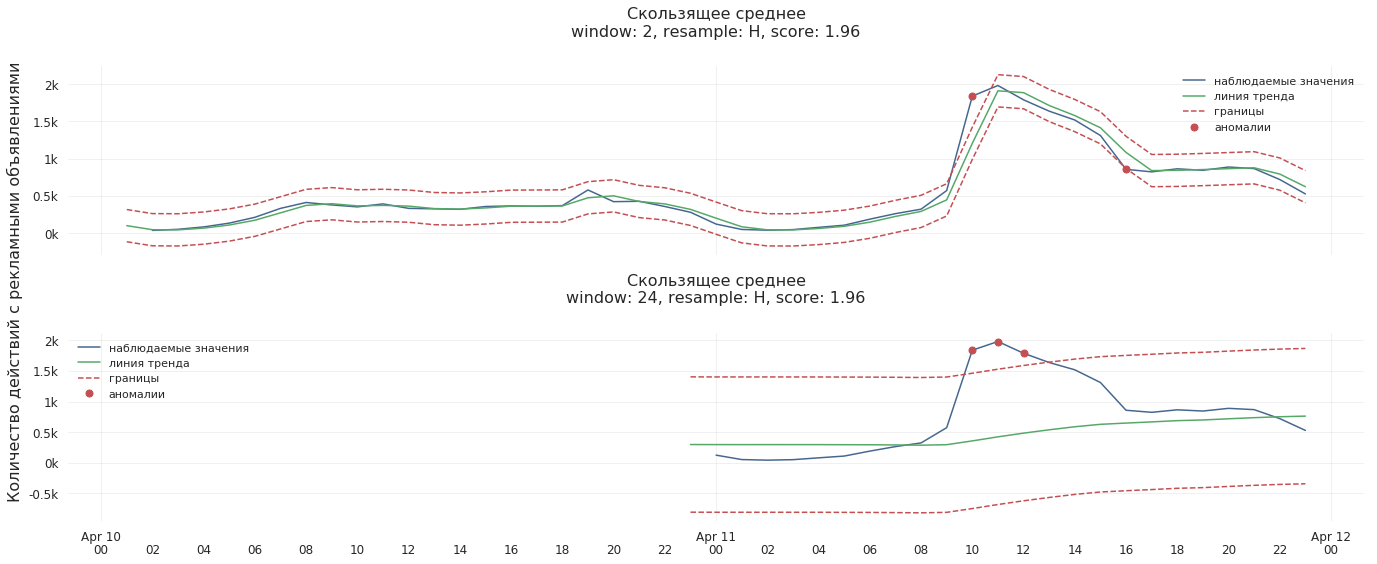

In [30]:
fig, axes = plt.subplots(nrows=2, figsize=(19, 8), sharex=True)
# возьмем данные за 10 и 11 апреля, по часам
moving_avg(df['2019-04-10':'2019-04-11'], resample_rule='H', window=2, plot=True, ax=axes.flatten()[0])
# окно 24
moving_avg(df['2019-04-10':'2019-04-11'], resample_rule='H', window=24, plot=True, ax=axes.flatten()[1])
for ax in axes.flatten():
    ax.set(xlabel='', ylabel='')
    ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 1))) #
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_minor_locator(mdates.HourLocator(range(0, 25, 2)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%H')) 
fig.text(0.0, 0.5, 'Количество действий с рекламными объявлениями', rotation='vertical', va='center', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

 Проблема обнаружилась и 8 апреля 

День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 4
День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 3


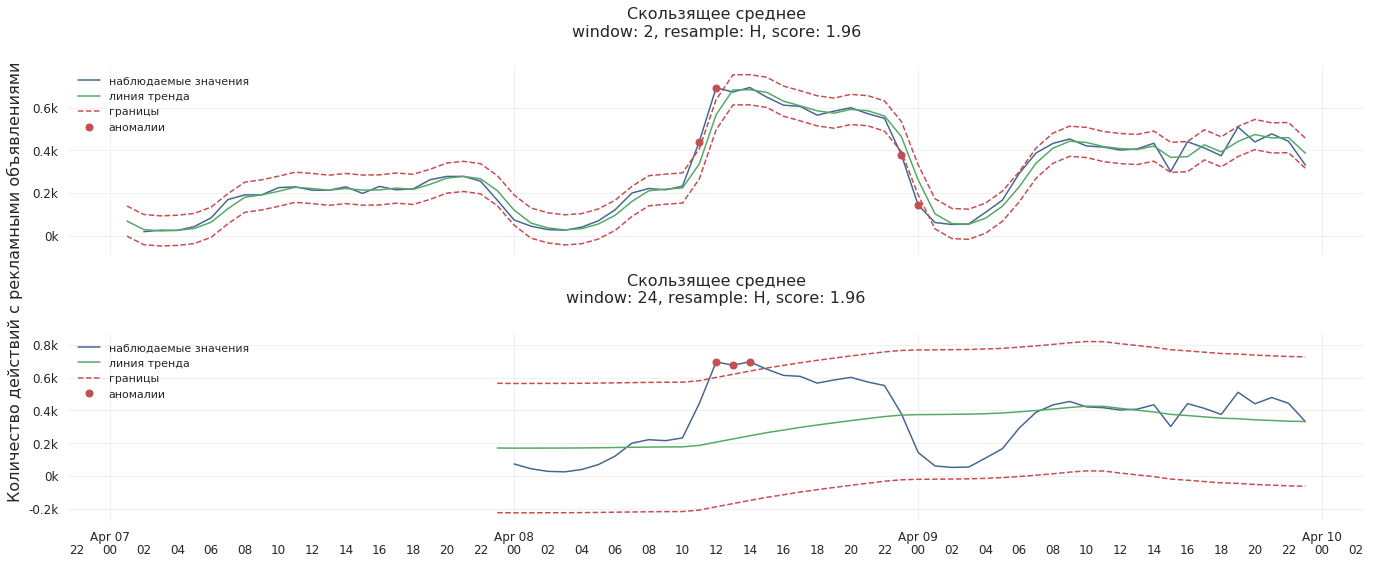

In [31]:
fig, axes = plt.subplots(nrows=2, figsize=(19, 8), sharex=True)
# ради интереса возьмем за три дня, окно 2
moving_avg(df['2019-04-07':'2019-04-09'], resample_rule='H', window=2, plot=True, ax=axes.flatten()[0])
# окно 24
moving_avg(df['2019-04-07':'2019-04-09'], resample_rule='H', window=24, plot=True, ax=axes.flatten()[1])
for ax in axes.flatten():
    ax.set(xlabel='', ylabel='')
    ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 1))) #
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_minor_locator(mdates.HourLocator(range(0, 25, 2)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%H')) 
fig.text(0.0, 0.5, 'Количество действий с рекламными объявлениями', rotation='vertical', va='center', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

Ещё можно использовать разные значения `score` для построения доверительных интервалов. Чем больше значение, тем более широкий будет интервал.

День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 5
День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 3
День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 2


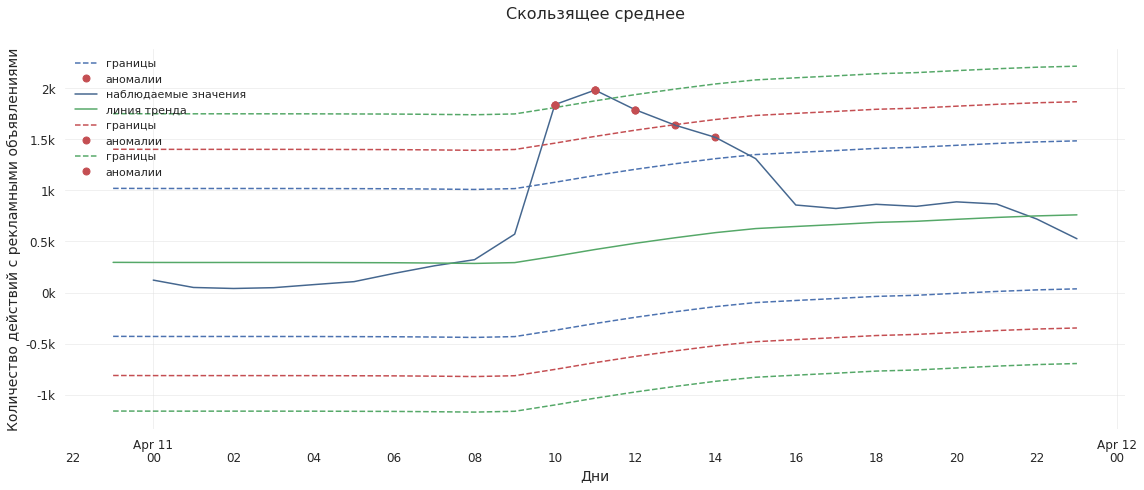

In [32]:
fig, ax = plt.subplots()
# берем день и предыдущий, чтобы сравнить
moving_avg(df['2019-04-10':'2019-04-11'], resample_rule='H', window=24, plot=True, ax=ax, score=1.282, 
           bound_param='b--', obs=False, trend=False)
moving_avg(df['2019-04-10':'2019-04-11'], resample_rule='H', window=24, plot=True, ax=ax)
moving_avg(df['2019-04-10':'2019-04-11'], resample_rule='H', window=24, plot=True, ax=ax, score=2.576, 
           bound_param='g--', obs=False, trend=False)

ax.set(title='Скользящее среднее')
ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 1))) #
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_minor_locator(mdates.HourLocator(range(0, 25, 2)))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%H'))   

#### 5 минут
Сначала я подумала, что для **5 минут** метод подходит в том случае, если использовать много предыдущих периодов. В случаях, когда их всего несколько, аномалии не находятся.   
Возьмем для примера данные за несколько пятиминуток и за часть дня, где наблюдался пик количества событий.  
Можно заметить, что если брать данные за 5 минут и сравнивать их с предыдущими 5 минутами, то ничего хорошего не выходит. 
В этом заключается очевидный недостаток: если сравнивать очень близкие периоды *(всего несколько пятиминуток)*, то алгоритм аномалии не находит, поскольку полученные значения не выходят за границы интервала. В этом случае помогает настройка параметров доверительных интервалов, но звучит как не самое интересное решение. Да и в целом выглядит не очень логично сравнивать маленькое число промежутков, особенно коротких: рост количества показов происходил постепенно, если считать по пятиминуткам (точнее, не настолько резко, чтобы алгоритм его заметил).   
---> just use more data   

**Но** ведь суть в том, чтобы просто смотреть всё ли хорошо с данными каждые 5 минут, а не сравнивать маленькие промежутки. Получается, что если агрегировать данные за 5 минут, а затем подсчитывать нужные показатели на основе данных за, например, предыдущий день (тоже разбитый на пятиминутки), то будет нормально. 

День: полный выбранный период
Все хорошо
День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 6


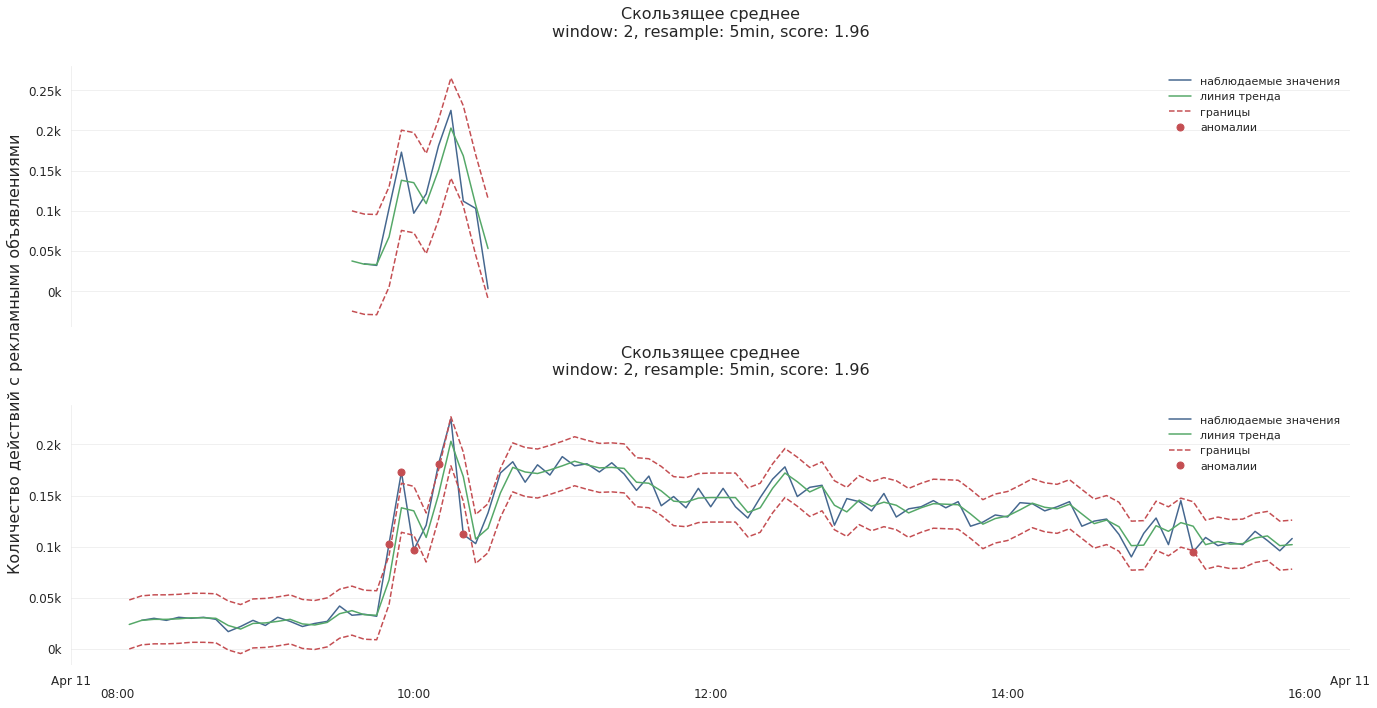

In [33]:
fig, axes = plt.subplots(nrows=2, figsize=(19,10), sharex=True)
# берем только час по пятиминуткам, на котором на самом деле есть аномалия --> doesnt work
moving_avg(df['2019-04-11 09:30:00':'2019-04-11 10:30:00'], resample_rule='5min', window=2, plot=True, 
           ax=axes.flatten()[0])
# для сравнения берем более широкий промежуток - с 8 утра до 16 дня, т.е. промежуток на котором был аномальный пик --> works
moving_avg(df['2019-04-11 08:00:00':'2019-04-11 16:00:00'], resample_rule='5min', window=2, plot=True, ax=axes.flatten()[1])
for ax in axes.flatten():
    ax.set(xlabel='', ylabel='')
    ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 1))) #
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_minor_locator(mdates.HourLocator(range(0, 25, 2)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%H:%M')) 
fig.text(0.0, 0.5, 'Количество действий с рекламными объявлениями', rotation='vertical', va='center', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

Посмотрим заодно и на параметры интервалов. Видно, что при 99% доверительном интервале находится поменьше аномалий, только основные. Детектируются аномалии за 8 апреля, когда подозрительный рост показов у кампании только начинался *(потом упал, а потом улетел)*, и за 11 апреля. Возможные минусы: кажется, есть ложные срабатывания. А потом алгоритму не нравятся уже привычные маленькие значения *(ночь)*. 

Note: здесь еще не используется параметр 'day'

День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 176
День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 117


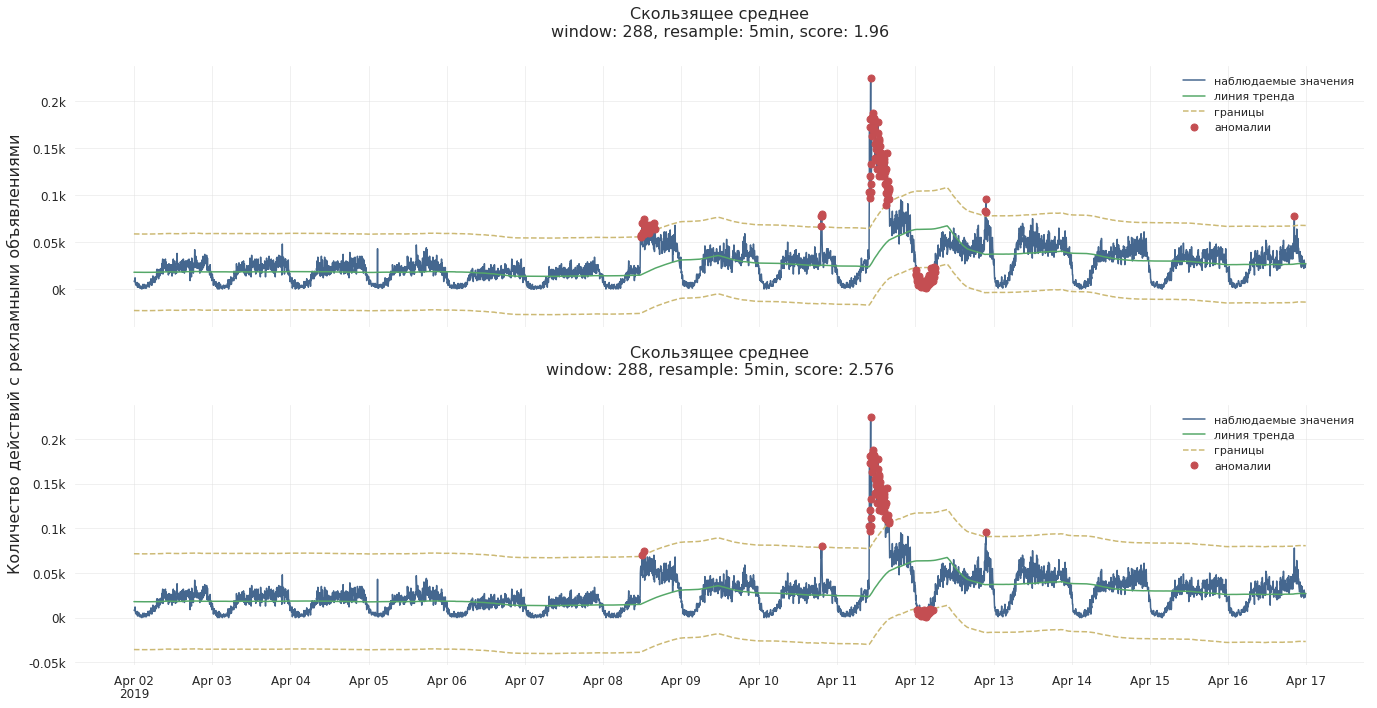

In [34]:
fig, axes = plt.subplots(nrows=2, figsize=(19, 10), sharex=True)
# сделаем линии желтенькими для разнообразия
moving_avg(df, resample_rule='5min', window=24*60//5, plot=True, ax=axes.flatten()[0], bound_param='y--')  
moving_avg(df, resample_rule='5min', window=24*60//5, plot=True, ax=axes.flatten()[1], score=2.576, bound_param='y--')  # 99%
for ax in axes.flatten():
    ax.set(xlabel='', ylabel='')
    ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 1))) #
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  
fig.text(0.0, 0.5, 'Количество действий с рекламными объявлениями', rotation='vertical', va='center', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

Как вариант, можно искать только те аномалии, которые оказались над верхней границей *(bounds='upper')*:

День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 71


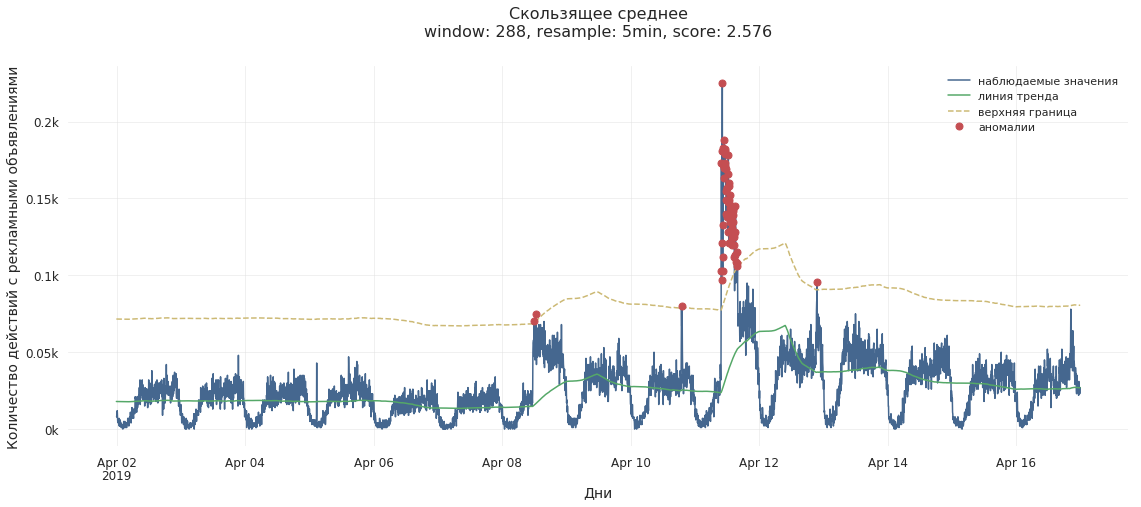

In [35]:
fig, ax = plt.subplots() 
moving_avg(df, resample_rule='5min', window=24*60//5, plot=True, ax=ax, score=2.576, bound_param='y--', bounds='upper')
#plt.tight_layout()
plt.show()

Общий вывод насчет этого подхода: it works с:
***

#### Moving Median?
Можно немного обновиться и использовать не среднее, а медиану. Для графиков по пятиминуткам с большим довер. интервалом получается получше

In [67]:
def moving_med(data, resample_rule='H', window=2, plot=False, score=1.96, ax=None, bound_param='r--', 
               obs=True, trend=True, day=None, extended=False):
    """Moving median.
    
    Параметры
    ---------
    data: pandas DataFrame
        Датасет
    resample_rule: str
        По какому периоду агрегировать данные (дни/часы и т.п.)
    window: int
        Размер окна
    plot: bool, optional
        True, если нужно вывести график
    scale: float, optional
        Z-значение для доверительного интервала
    ax: axis, optional
        Если объект axis уже создан (полезно при построении нескольких графиков сразу)
    bound_param: str, optional
        Цвет и тип линии для CI
    obs: bool, optional
        True, если на графике нужна линия наблюдаемых значений
    trend: bool, optional
        True, если на графике нужна линия тренда (среднего)
    day:
        День, для которого смотрим статистику
    extended:
        True, если нужно вывести аномальные события
    """
    
    data_res = pd.DataFrame(data.resample(rule=resample_rule).size(), columns=['cnt'])
    rolling_median = data_res.rolling(window=window).median()  # !

    # доверительные интервалы
    std = np.std(data_res[window:] - rolling_median[window:])
    lower_bound = rolling_median - (score * std)
    upper_bound = rolling_median + (score * std)

    # ищем аномалии
    anomalies = pd.DataFrame(index=data_res.index, columns=data_res.columns)
    anomalies[data_res < lower_bound] = data_res[data_res < lower_bound]
    anomalies[data_res > upper_bound] = data_res[data_res > upper_bound]
    
    if plot:
        if ax is None:        
            fig, ax = plt.subplots()  
        if obs:
            ax.plot(data_res[window:], label='наблюдаемые значения', color='#45678f')
        if trend:
            ax.plot(rolling_median, 'g', label='линия тренда')
        ax.plot(upper_bound, bound_param, label='границы')
        ax.plot(lower_bound, bound_param)
        ax.plot(anomalies, 'ro', markersize=7, label = 'аномалии')
        ax.set_frame_on(False)
        ax.yaxis.set_major_formatter(FuncFormatter( lambda y, p: '{:,g}k'.format(y/1000)))
        ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 2)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax.xaxis.set_minor_locator(mdates.YearLocator(month=4, day=2))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%Y'))    
        #ax.axes.set_ylim(bottom=0)  # границы интервала иногда бывают ниже 0 
        ax.set(xlabel='Дни', ylabel='Количество действий с рекламными объявлениями', 
               title='Скользящяя медиана\nwindow: {}, resample: {}, score: {}'.format(window, resample_rule, score))
        ax.legend(loc='best', framealpha=0)
        ax.grid(True, color='#e2e2e2', alpha=0.5)
    
    # уведомление
    return anomaly_alert(anomalies, day, extended)

День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 171
День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 78


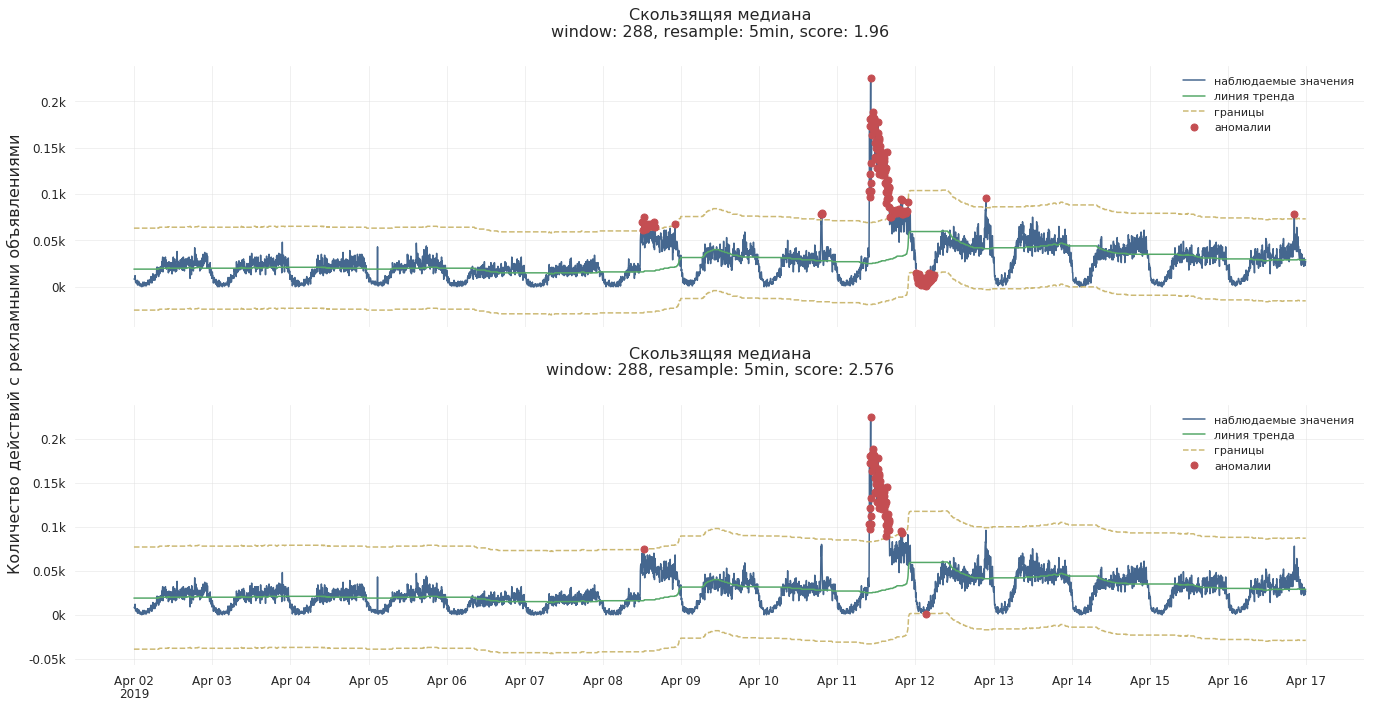

In [37]:
fig, axes = plt.subplots(nrows=2, figsize=(19, 10), sharex=True)
moving_med(df, resample_rule='5min', window=24*60//5, plot=True, ax=axes.flatten()[0], bound_param='y--')  
moving_med(df, resample_rule='5min', window=24*60//5, plot=True, ax=axes.flatten()[1], score=2.576, bound_param='y--')  # 99%
for ax in axes.flatten():
    ax.set(xlabel='', ylabel='')
    ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 1))) #
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  
fig.text(0.0, 0.5, 'Количество действий с рекламными объявлениями', rotation='vertical', va='center', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

***

### Exponential Moving Average
Как вариант можно попробовать экспоненциальное скользящее среднее. 

In [68]:
def EMA(data, resample_rule='H', window=2, plot=False, score=1.96, ax=None, bound_param='r--', 
        obs=True, trend=True, day=None, extended=False):
    """Exponential Moving Average.
    
    Параметры
    ---------
    data: pandas DataFrame
        Датасет
    resample_rule: str
        По какому периоду агрегировать данные (дни/часы и т.п.)
    window: int
        Размер окна
    plot: bool, optional
        True, если нужно вывести график
    scale: float, optional
        Z-значение для доверительного интервала
    ax: axis, optional
        Если объект axis уже создан (полезно при построении нескольких графиков сразу)
    bound_param: str, optional
        Цвет и тип линии для CI
    obs: bool, optional
        True, если на графике нужна линия наблюдаемых значений
    trend: bool, optional
        True, если на графике нужна линия тренда (среднего)
    day:
        День, для которого смотрим статистику
    extended:
        True, если нужно вывести аномальные события
    """
    
    data_res = pd.DataFrame(data.resample(rule=resample_rule).size(), columns=['cnt'])
    exp_ma = data_res.ewm(span=window, adjust=False).mean()  # !

    # доверительные интервалы
    std = np.std(data_res[window:] - exp_ma[window:])
    lower_bound = exp_ma - (score * std)
    upper_bound = exp_ma + (score * std)

    # ищем аномалии
    anomalies = pd.DataFrame(index=data_res.index, columns=data_res.columns)
    anomalies[data_res < lower_bound] = data_res[data_res < lower_bound]
    anomalies[data_res > upper_bound] = data_res[data_res > upper_bound]
    
    if plot:
        if ax is None:        
            fig, ax = plt.subplots()  
        if obs:
            ax.plot(data_res[window:], label='наблюдаемые значения', color='#45678f')
        if trend:
            ax.plot(exp_ma, 'g', label='линия тренда')
        ax.plot(upper_bound, bound_param, label='границы')
        ax.plot(lower_bound, bound_param)
        ax.plot(anomalies, 'ro', markersize=7, label = 'аномалии')
        ax.set_frame_on(False)
        ax.yaxis.set_major_formatter(FuncFormatter( lambda y, p: '{:,g}k'.format(y/1000)))
        ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 2)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax.xaxis.set_minor_locator(mdates.YearLocator(month=4, day=2))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%Y'))    
        ax.set(xlabel='Дни', ylabel='Количество действий с рекламными объявлениями', 
               title='Exponential Moving Average\nwindow: {}, resample: {}, score: {}'.format(window, resample_rule, score))
        ax.legend(loc='best', framealpha=0)
        ax.grid(True, color='#e2e2e2', alpha=0.5)
    
    # уведомление
    return anomaly_alert(anomalies, day, extended)

Для сравнения:  
1. MA  
2. EMA  

День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 117
День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 100


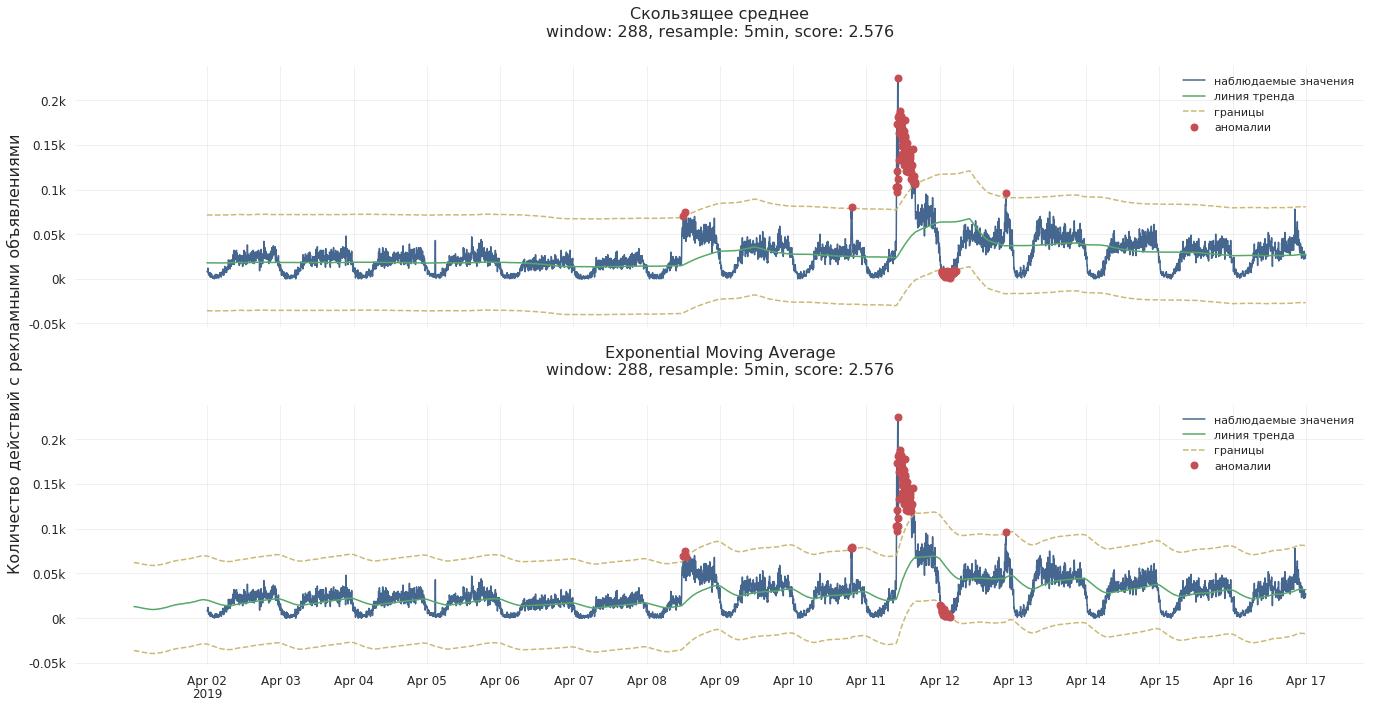

In [39]:
fig, axes = plt.subplots(nrows=2, figsize=(19, 10), sharex=True) 
moving_avg(df, resample_rule='5min', window=24*60//5, plot=True, ax=axes.flatten()[0], score=2.576, bound_param='y--')
EMA(df, resample_rule='5min', window=24*60//5, plot=True, ax=axes.flatten()[1], score=2.576, bound_param='y--')

for ax in axes.flatten():
    ax.set(xlabel='', ylabel='')
    ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 1))) #
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  
fig.text(0.0, 0.5, 'Количество действий с рекламными объявлениями', rotation='vertical', va='center', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

Если взять период за два дня (48\*60/5), то получается весьма здорово как при использовании SMA, так и при EMA.  
В общем, в зависимости от периода стоит подбирать параметры окна и размер интервала *(5min, H и т.п.)*. В случае пятиминуток хорошо себя показывает 99%, в других - 95% тоже неплох.  

День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 74
День: полный выбранный период
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 72


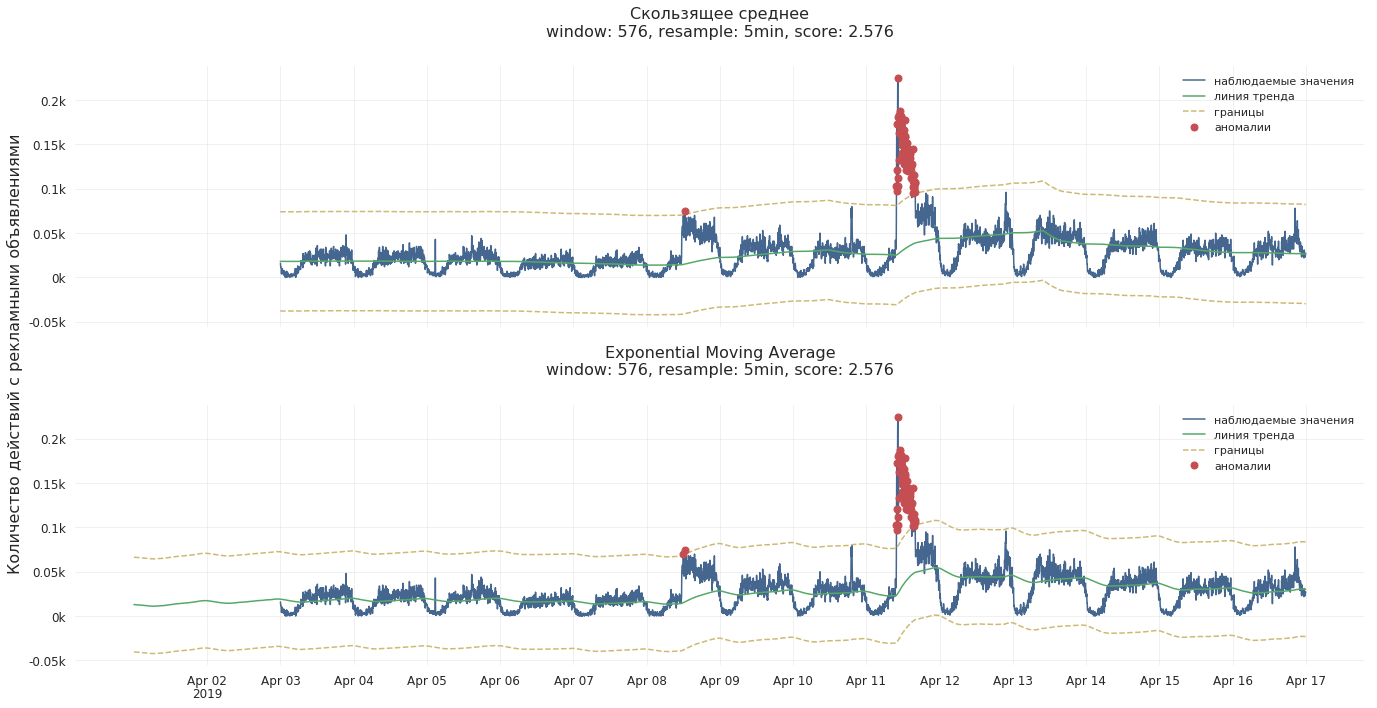

In [40]:
fig, axes = plt.subplots(nrows=2, figsize=(19, 10), sharex=True) 
moving_avg(df, resample_rule='5min', window=2*24*60//5, plot=True, ax=axes.flatten()[0], score=2.576, bound_param='y--')
EMA(df, resample_rule='5min', window=2*24*60//5, plot=True, ax=axes.flatten()[1], score=2.576, bound_param='y--')

for ax in axes.flatten():
    ax.set(xlabel='', ylabel='')
    ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 1))) #
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  
fig.text(0.0, 0.5, 'Количество действий с рекламными объявлениями', rotation='vertical', va='center', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

Вообще, если мы хотим понять, произошло ли что-то в данных только за прошлый день, нас вряд ли интересует количество аномалий на всем графике. Соответственно, стоит использовать параметр **'day'** с:  

Данные: 7-11 апреля   
1) Интересующий день: 9 апреля   
2) Интересующий день: 11 апреля 

День: 2019-04-09
Все хорошо
День: 2019-04-11
Что-то пошло не так, пора проверить графики.
Найдено аномалий: 5


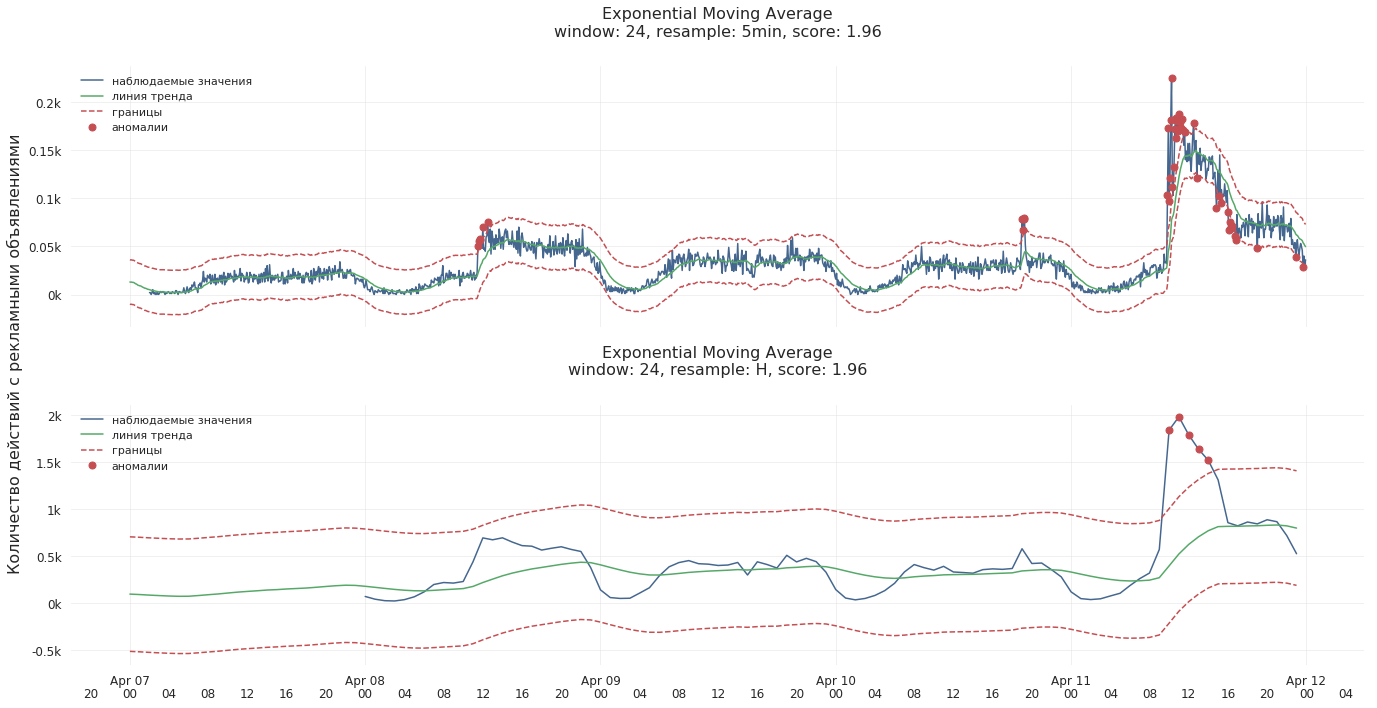

In [41]:
fig, axes = plt.subplots(nrows=2, figsize=(19, 10), sharex=True)
# 2019-04-12 
EMA(df['2019-04-07':'2019-04-11'], resample_rule='5min', window=24, plot=True, ax=axes.flatten()[0]
           , day='2019-04-09')
# 2019-04-11
EMA(df['2019-04-07':'2019-04-11'], resample_rule='H', window=24, plot=True, ax=axes.flatten()[1]
           , day='2019-04-11')
for ax in axes.flatten():
    ax.set(xlabel='', ylabel='')
    ax.xaxis.set_major_locator(mdates.DayLocator(range(2, 32, 1))) #
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.xaxis.set_minor_locator(mdates.HourLocator(range(0, 25, 4)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('\n%H')) 
fig.text(0.0, 0.5, 'Количество действий с рекламными объявлениями', rotation='vertical', va='center', ha='center', fontsize=16)
plt.tight_layout()
plt.show()

День: полный выбранный период
Все хорошо


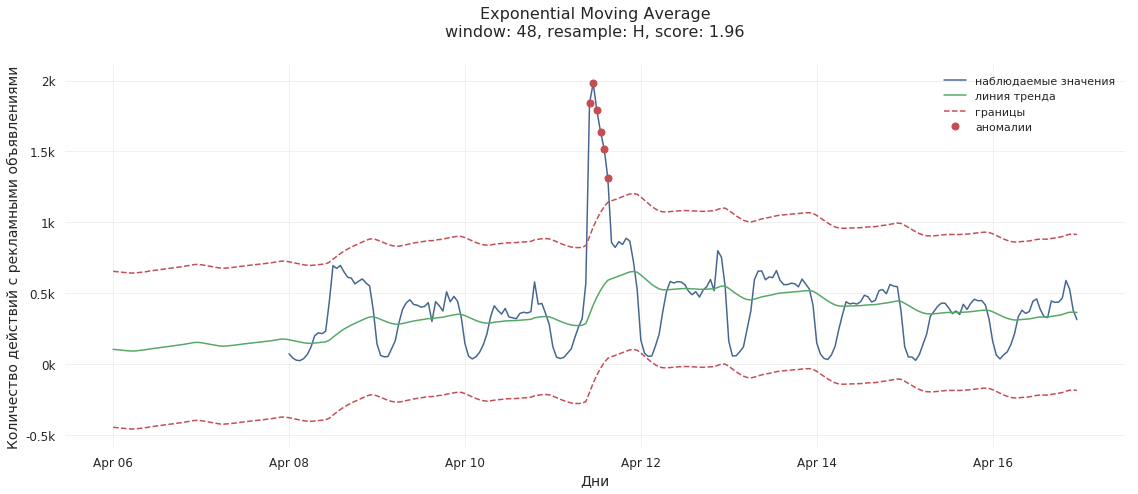

In [74]:
fig, ax = plt.subplots()
EMA(df['2019-04-06':'2019-04-16'], resample_rule='H', window=48, plot=True, ax=ax, day='2019-04-16', extended=True)  

![](https://pp.userapi.com/c856028/v856028527/47871/RnQWzNEyeLc.jpg)

***